# Introduction to Reinforcement Learning
This lecture notes is taken to study for the fundamental concepts of reinforcement learning. Notes for each course and textboot will be taken in a different jupyter notebook. This notebook containes the notes of the [Udemy Course - _Reinforcement Learning in Python_](https://www.udemy.com/course/artificial-intelligence-reinforcement-learning-in-python/) and [Coursera Course - _Fundamentals in Reinforcement Learning_](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning?specialization=reinforcement-learning)

> **_Important Note:_**
> - Probability knowledge
> - Python fundamental knowledge \
> are required for understanding these lectures.

## Multi-Armed Bandit Problem
### Explore - Exploit Dilemma
The exploration-exploitation dilemma is a very general problem that can be encountered in most of the data driven decision making process when there exists some kind of feedback loop between data gathering and decisions making. In other words, as soon as a model is no longer « spectator » but becomes « actor » of the way data are collected, the exploration-exploitation dilemma arise.

Let’s consider two examples to illustrate our point: first, the offline training of a face detection model and, second, the online training of a model that predicts the click through rates of some ads.

In the case of the face detector model, data are collected before the training. Once it has been trained, the model is used in some way or another but no new data are collected and, so, there is no feedback loop to be careful about. Exploration-exploitation trade-off is not a concern: the model has no role in the data gathering process and its outputs can be used as such with no further exploration required.

![](./images/image1.png)

Conversely, in the click prediction case, the model is continuously updated and training happens at the same time as data are collected. Data observed so far are used to train a model, the model is used to select the best ads to be displayed, new gathered data (click or no click) can be used to update the model and so on. The model is then « actor » in the data gathering process and the exploration-exploitation trade-off needs to be considered carefully.

![](./images/image2.png)

Indeed, with no exploration, a model that wrongly predicts poor performances for an ad (either because we have no data, inaccurate data or outdated data for this ad) won’t have any chances to correct itself with new observations because the ad won’t be displayed anymore. Considering some exploration will make it possible to give a try to this ad and collect more data that prove the model wrong and update it.

In general, this kind of __online learning__ process is often required either when there is not enough past data to train a reliable model (cold start problem) or when data are evolving through the time (non-stationary problem). In both cases, the knowledge derived from data observed so far doesn’t allow us to identify the best decision to be taken with absolute certainty (the best ad to display in our example). We then have to make a fundamental choice between the best decision according to our current knowledge (exploitation) and any other decision that could be shown to be the best with more information (exploration).

To summarize, explore - exploit dilemma for reinforcement learning is that the corresponding agent of the system have to choose exploring the situations or exploitation for best result since it cannot achieve both of them simultaneously.

### Epsilon - Greedy Algorithm
__Problem Definition:__ Assume you (or an agent) in a casino and there are several slot machines (bandits). These slot machines are giving a reward 1 with a certain probability, and 0 othwerwise. The reward probabilities for each slot machine is unknown and the goal is maximizing the reward in each play. In this concept, we will call the slot machines as bandits.

How do we solve this problem? Because of explore - exploit dilemma _- we cannot achieve exploration and explotation at the same time -_, we have to create a balance between them. Maybe, we can start with a random choice of bandits, and after that, we can choose the one with the best win rate.

Pseudocode for greedy algorithm:

    while True:
        j = argmax(predicted bandit means)
        x = play bandit j and get reward
        bandits[j].update_mean(x)

- Choosing the best MLE win rate doesn't work, which is called greedy method.
- For us, greedy means picking the bandit with highest MLE win rate, with no regard to confidence in prediction or amount of data collected.

__Epsilon-Greedy Algorithm:__ Epsilon greedy is a method to solve the no exploration problem in the pure greedy algorithm. In this algorithm, the agent choose exploration with a small probability (epsilon), in other cases, it chooses the bandit like a greedy algorithm. Typical values for epsilon is 0.05 or 0.1.

Pseudocode for epsilon-greedy Algorithm:

    while True:
        p = random number in [0, 1]
        if p < epsilon:
            j = choose a random bandit
        else:
            j = argmax(predicted bandit means)
        x = play bandit j and get reward
        bandits[j].update_mean(x)
        
- The purpose of exploration (with nonzero epsilon) is so the agent can collect data about each bandit.
- The problem is for a constant epsilon the exploration will never stop even if we have enough data to choose the highest one and this situation will cause a loss in the optimal reward.
- We can use decaying epsilons _-with respect to time-_ which can be helpful for stationary problems but in non-stationary problems, constant epsilon could be more helpful.


> Small trick for mean calculation:
> $$ \overline{X}_N = \frac{1}{N} \sum_{i=1}^{N} X_i $$
> $$ \overline{X}_N = \frac{1}{N} (\sum_{i=1}^{N-1} X_i + X_N) $$
> $$ \overline{X}_N = \frac{1}{N} ((N-1) * \overline{X}_{N-1} + X_N) $$
> $$ \overline{X}_N = \frac{N-1}{N}\overline{X}_{N-1} + \frac{1}{N}X_N $$
> $$ \overline{X}_N = \overline{X}_{N-1} + \frac{1}{N}(X_N - \overline{X}_{N-1}) $$

In [2]:
# library imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Callable
%matplotlib inline

In [3]:
# bandit class implementation
class Bandit:
    def __init__(self, probability: float):
        self.probability = probability
        self.num_samples = 0
    
    def pull(self):
        self.num_samples += 1
        if random.random() < self.probability:
            return 1
        else:
            return 0

In [37]:
# agent class implementation
class Agent:
    def __init__(self, bandit_probabilities: List[float]):
        self.choose = None
        self.choose_params = None
        self.bandits = [Bandit(prob) for prob in bandit_probabilities]
        self.bandit_means = np.zeros(len(self.bandits))

    def set_agent_algorithm(self, agent_algorithm: Callable[[], int], **params):
        self.choose = agent_algorithm.__get__(self)
        self.choose_parameters = params

    def update_bandit(self, reward: int, bandit_num: int):
        n = self.bandits[bandit_num].num_samples
        self.bandit_means[bandit_num] += 1 / n * (reward - self.bandit_means[bandit_num])

    def play_one_turn(self):
        bandit_num = self.choose()
        reward = self.bandits[bandit_num].pull()
        self.update_bandit(reward, bandit_num)
        return reward

In [5]:
# experiment class implementation
class Experiment:
    def __init__(self, agent: Agent):
        self.agent = agent
        self.iterations = []
        self.mean_rewards = [0]
        self.means = []
        self.legend = []

    def calculate_mean_reward(self, reward):
        mean_reward = float(self.mean_rewards[-1])
        mean_reward += (reward - mean_reward) / len(self.mean_rewards)
        return mean_reward
    
    def run(self, iter_num: int):
        for i in tqdm(range(1, iter_num + 1)):
            self.iterations.append(i)
            self.mean_rewards.append(self.calculate_mean_reward(self.agent.play_one_turn()))
            self.means.append(self.agent.bandit_means.copy())
            
    def plot_mean_rewards(self, color='b'):
        plt.rcParams["figure.figsize"] = (20,10)
        plt.plot(self.iterations, self.mean_rewards[1:], c=color)
        plt.xlabel("Iteration Number")
        plt.ylabel("Mean Reward")
        plt.ylim([0, 1])
        self.legend.append("reward")

    def plot_bandit_estimates(self, colors=List[str]):
        means = np.stack(self.means, axis=1)
        for i in range(means.shape[0]):
            plt.plot(self.iterations, means[i], c=colors[i])
            self.legend.append("bandit_{} prob est".format(i))
        plt.xlabel("Iteration Number")
        plt.ylabel("Estimations for bandits")
        plt.ylim([0, 1])
        plt.legend(self.legend)

Now, since we finished implementation of the bandit, agent and experiment classes, we can start experiments. Let's start with pure greedy approach and reward return.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 80755.68it/s]


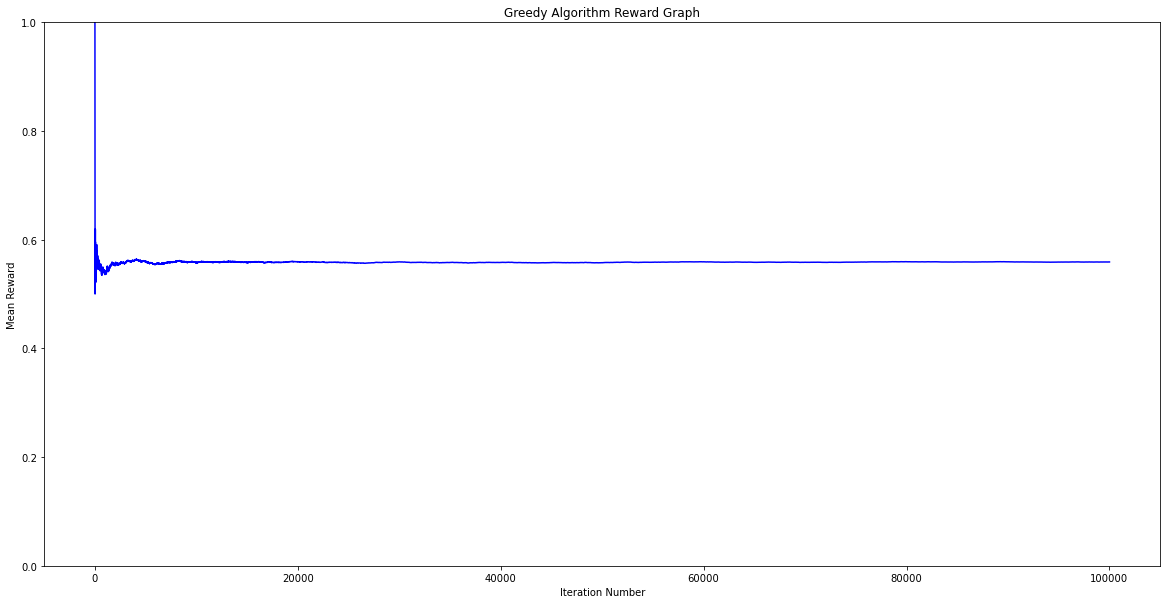

In [6]:
# implementing pure greedy algorithm
def use_greedy(self) -> int:
    bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_greedy)
experiment = Experiment(agent)
experiment.run(100000)
experiment.plot_mean_rewards()
_ = plt.title("Greedy Algorithm Reward Graph")

When we run the cell above several times, final reward will change significantly since the reward depends on the initial random start. It's a little problem. In order to solve this issue, let's implement epsilon-greedy algorithm.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 88994.81it/s]


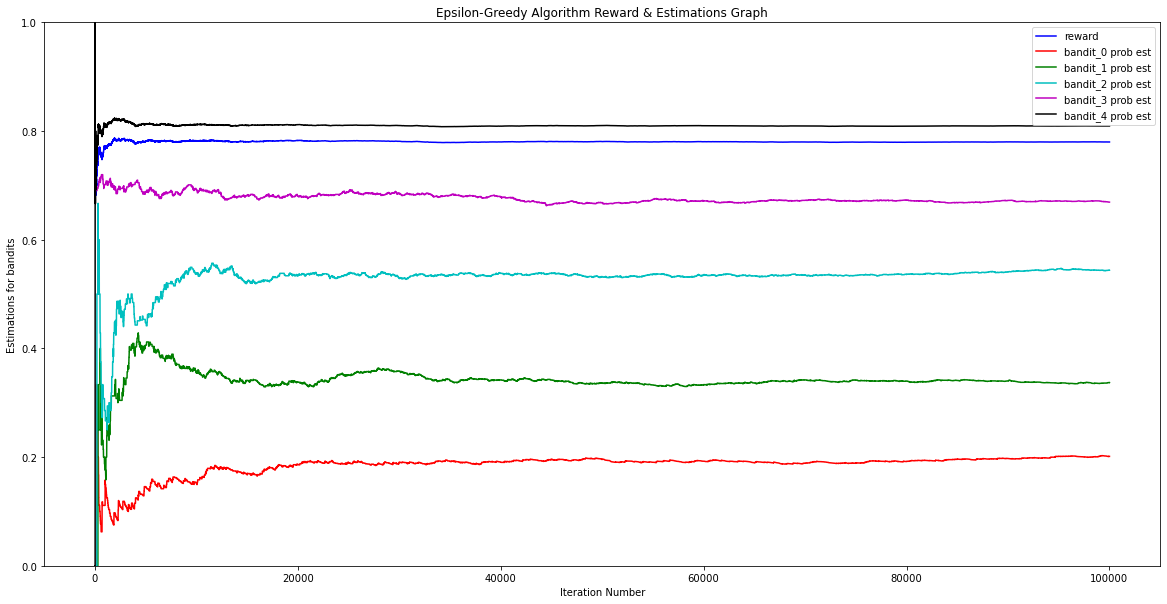

In [38]:
# implementing epsilon-greedy algorithm
def use_epsilon_greedy(self) -> int:
    if random.random() < self.choose_parameters["epsilon"]:
        bandit_num = random.randint(0, len(self.bandits) - 1)
    else:
        bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_epsilon_greedy, epsilon=0.1)
experiment = Experiment(agent)
experiment.run(100000)
experiment.plot_mean_rewards()
experiment.plot_bandit_estimates(colors)
_ = plt.title("Epsilon-Greedy Algorithm Reward & Estimations Graph")

If we run the cell above several times, although the first 20,000 iteration steps are different in each time, the final estimation and reward results will become almost same. Now, analyze the reward and epsilon value relation for running several experiments with different epsilon values:

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 84923.80it/s]


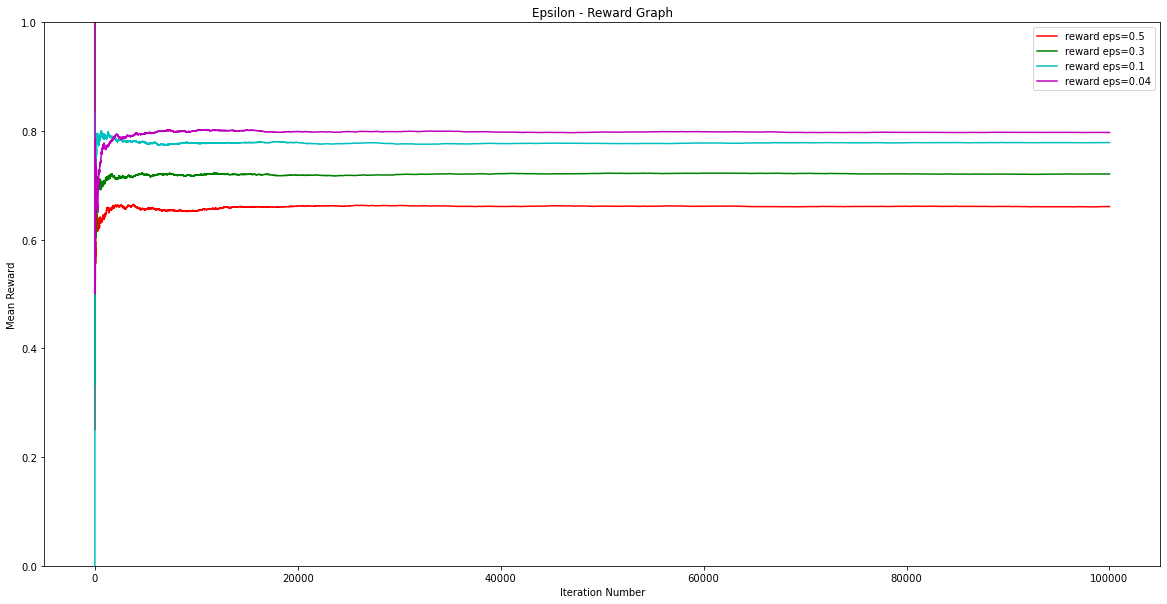

In [9]:
# analyzing epsilon value - reward relation
def use_epsilon_greedy(self) -> int:
    if random.random() < self.choose_parameters["epsilon"]:
        bandit_num = random.randint(0, len(self.bandits) - 1)
    else:
        bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
epsilons = [0.5, 0.3, 0.1, 0.04]
colors = ['r', 'g', 'c', 'm', 'k']
legend = []

for i, eps in enumerate(epsilons):
    agent = Agent(bandit_probs)
    agent.set_agent_algorithm(use_epsilon_greedy, epsilon=eps)
    experiment = Experiment(agent)
    experiment.run(100000)
    experiment.plot_mean_rewards(color=colors[i])
    legend.append("reward eps={}".format(eps))
_ = plt.legend(legend)
_ = plt.title("Epsilon - Reward Graph")

The lower the epsilon, the better the final result. However, the problem is at the beginning of the iteration, the convergence to the best reward result become slower. We can solve this issue by making epsilon as a function like: $$ \epsilon \propto 1/t $$

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 81328.92it/s]


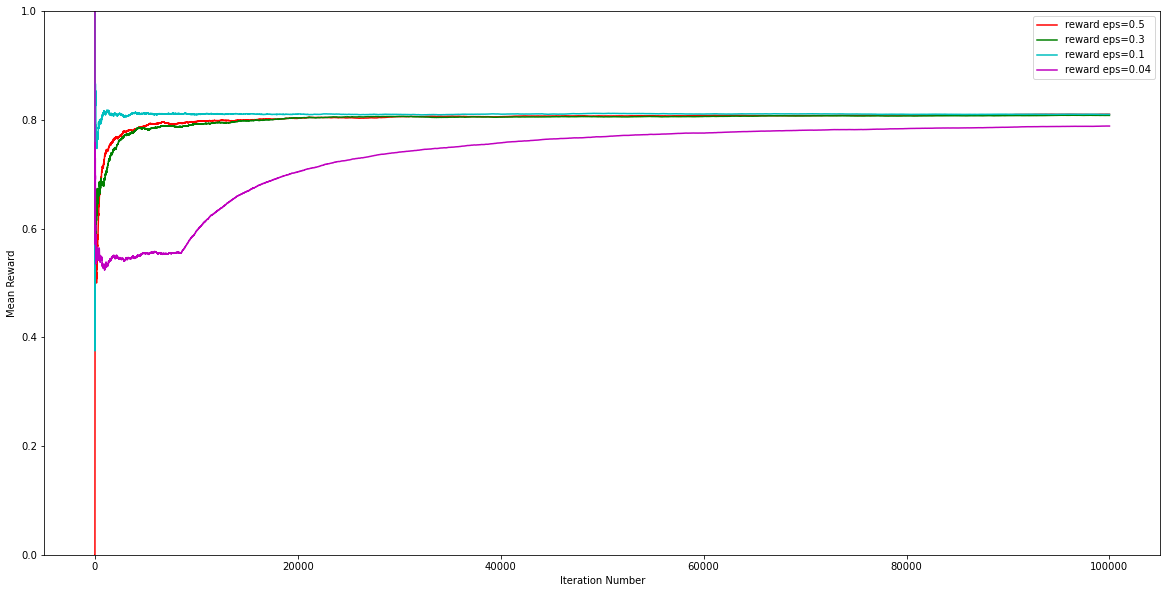

In [81]:
# analyzing epsilon - reward relation with decaying epsilon
def use_epsilon_greedy(self) -> int:
    self.choose_parameters["iter_num"] += 1
    if random.random() < self.choose_parameters["epsilon"]/math.sqrt(self.choose_parameters["iter_num"]):
        bandit_num = random.randint(0, len(self.bandits) - 1)
    else:
        bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
epsilons = [0.5, 0.3, 0.1, 0.04]
colors = ['r', 'g', 'c', 'm', 'k']
legend = []

for i, eps in enumerate(epsilons):
    agent = Agent(bandit_probs)
    agent.set_agent_algorithm(use_epsilon_greedy, epsilon=eps, iter_num = 0)
    experiment = Experiment(agent)
    experiment.run(100000)
    experiment.plot_mean_rewards(color=colors[i])
    legend.append("reward eps={}".format(eps))
_ = plt.legend(legend)
_ = plt.title("Decaying Epsilon - Reward Graph")

As you can see, for all epsilon values, the final result is converges to a certain value even for smaller epsilons convergence is very slow. However, the trade off for this situation is that, the current problem is stationary, i.e., the probabilities of bandits don't change. If it is a non-stationary problem, then the decaying epsilon will cause problems since it prevent the agent from exploring new probability changes with very small epsilon values.

### Optimistic Initial Values
- Simple modification of purely greedy method.
- No need for epsilon or random exploration.

Previously, the initial mean for each bandit was 0 and we started to increase it with exploration. However, by using higher values (above 1) we can decrease all of them one by one from a certain value, and in this way, we can explore all of the bandits at the beginning of the iterations and we can achieve this by using purely greedy algorithm. However, again, this methods works only for stationary problems since after a certain iteration, the algorithm will stick with the bandit whose mean value is the highest.

> Another problem with this approach is, initial value choice can be critical for certain situations.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 80882.71it/s]


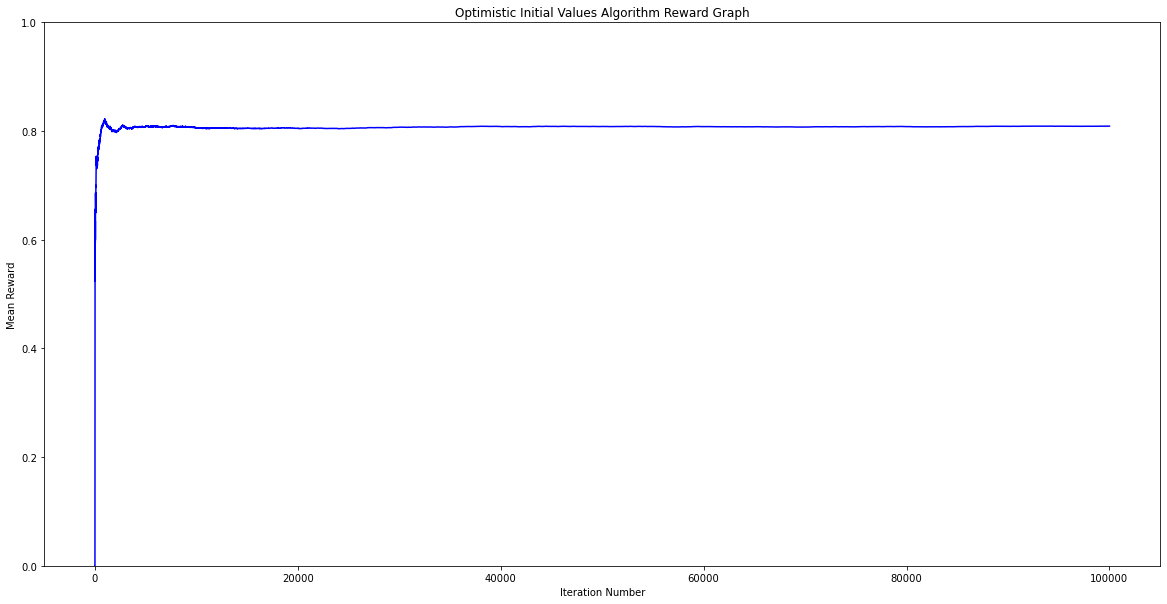

In [39]:
# implementing optimistic initial values algorithm
def use_greedy(self) -> int:
    bandit_num = np.random.choice(np.argwhere(self.bandit_means == np.max(self.bandit_means)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_greedy)
agent.bandit_means.fill(5)
for bandit in agent.bandits:
    bandit.num_samples = 1
experiment = Experiment(agent)
experiment.run(100000)
experiment.plot_mean_rewards()
_ = plt.title("Optimistic Initial Values Algorithm Reward Graph")

It's clear that the algorithm is working very efficiently for stationary problems. However, since there is no explorations, the mean estimations of the bandits cannot be estimated correctly with this algorithm since when the estimation for a bandit become lower than at least one of them, exploration for this bandit is stopped, which is demonstrated in the figure below:

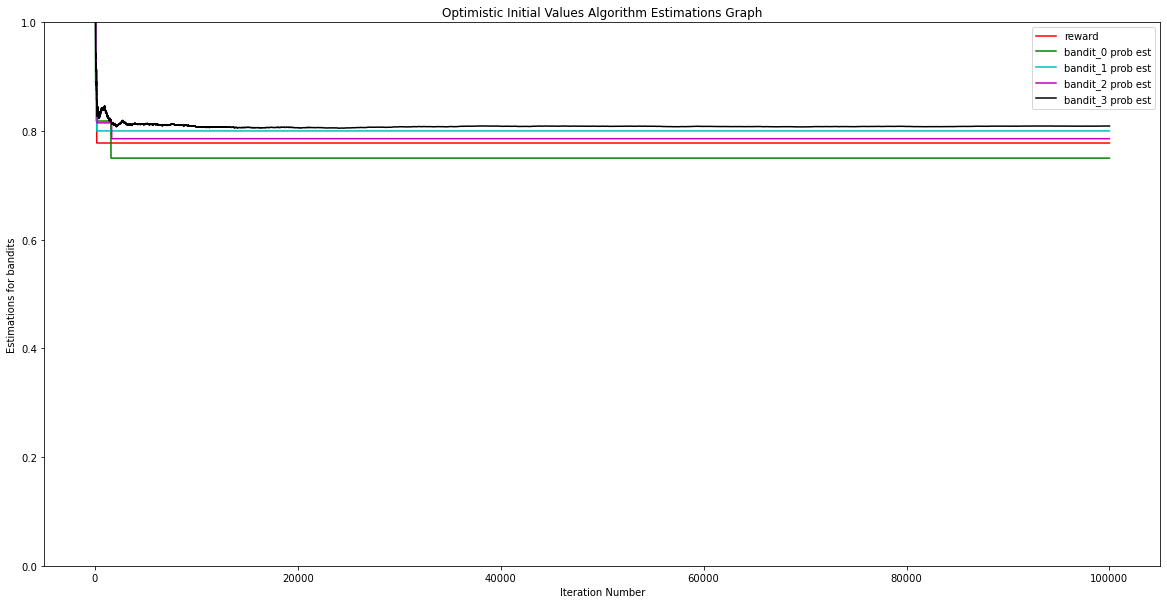

In [41]:
plt.clf()
experiment.plot_bandit_estimates(colors)
_ = plt.title("Optimistic Initial Values Algorithm Estimations Graph")

### Upper Confidence Bound Algorithm
In order to be confident about our probability estimations, we need to collect more samples. In upper confidence bound algorithm, we will create a higher upper bound for the bandits whose collected samples are not enought. Consider the equation: $$ p(mean_{sample} - mean_{true} \geq error) \leq function(error) $$
We can create a function like that: $$ p(mean_{sample} - mean_{true} \geq t) \leq \frac{1}{t} $$
However, this inequality is not good enough. Instead we can use actual, more useful inequalities like Markow or Chebyshev inequality. For this upper confidence bound algorithm, mostly Hoeffding's inequality is used:
$$ p(\overline{X}_n - E(X) \geq t) \leq e^{-2nt^2} $$

Pseudocode for upper confidence bound algorithm: $$ equation = \overline{X}_{n_j} + \sqrt{2\frac{logN}{n_j}} $$

    while True:
        j = argmax(equation)
        x = pull arm j and get reward
        bandits[j].update_mean(x)

For the upper bound equation: Take RHS of Hoeffding's inequality and solve for t: $$ p = e^{-2n_jt^2} \iff t = \sqrt{\frac{-logp}{2n_j}} $$
We decide to set: $$ p = N^{-4} $$
and the upper confidence bound algorithm is obtained.

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 61596.80it/s]


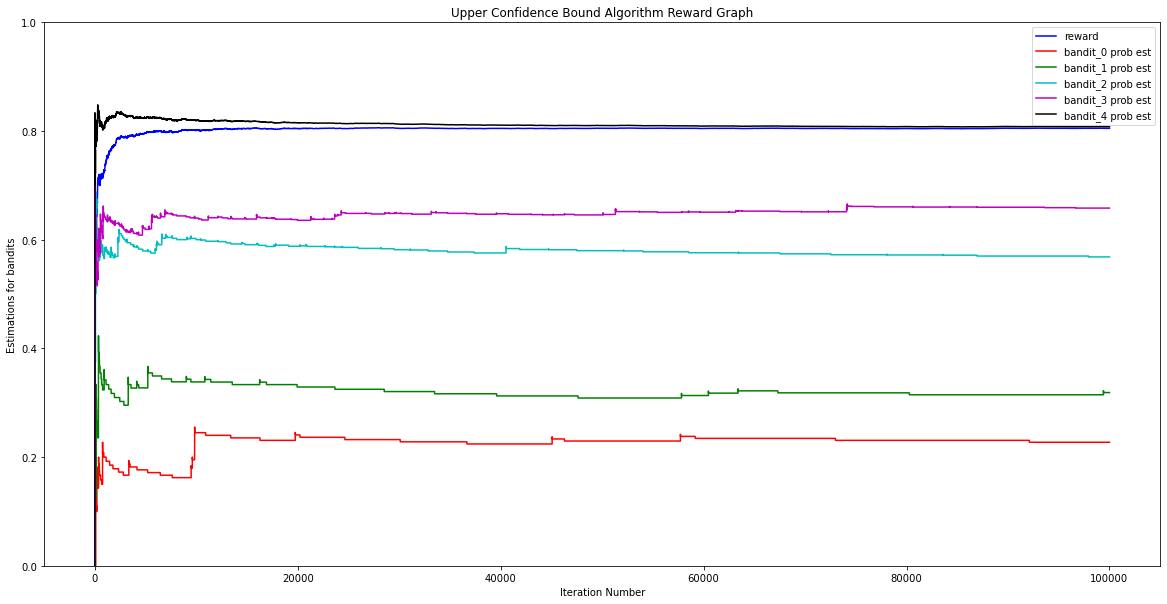

In [47]:
# implementation of upper confidence bound implementation
def use_greedy(self) -> int:
    N = sum([b.num_samples for b in self.bandits])
    confidence = lambda n: math.sqrt(2 * math.log(N) / n)
    upper_bound_arr = [self.bandit_means[i] + confidence(self.bandits[i].num_samples) for i in range(len(self.bandits))]
    upper_bound_arr = np.asarray(upper_bound_arr)
    bandit_num = np.random.choice(np.argwhere(upper_bound_arr == np.max(upper_bound_arr)).squeeze(axis=1))
    return bandit_num


bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_greedy)
for bandit in agent.bandits:
    bandit.num_samples = 1
experiment = Experiment(agent)
experiment.run(100000)
experiment.plot_mean_rewards()
experiment.plot_bandit_estimates(colors)
_ = plt.title("Upper Confidence Bound Algorithm Reward Graph")

In order to obtain the probability estimates for each bandit, the upper confidence bound algorithms gives a better result than optimistic initial value theory since if the sample for a bandit is not enough, the algorithm prioritizes to get samples from that bandit. 

### Thompson Sampling - Bayesian Bandits
In Bayesian Machine Learning, everything has a distribution since everything is assumed as a random variable. In this aspect, each bandit will have a probability distribution instead of their estimates.

> **Bayes' Rule:**
> $$ p(\theta | X) = \frac{p(X | \theta)p(\theta)}{p(X)} $$
> $$ p(\theta | X) = \frac{p(X | \theta)p(\theta)}{\int p(X | \theta)p(\theta)d\theta} $$
> The denominator is usually an impossible to solve integral for our cases. We could apprixmate with Monte Carlo, but we need to run in real-time!

In probability theory, prior probability is the probability of an event before we see the data. In Bayesian Inference, the prior is our guess about the probability based on what we know now, before new data becomes available. After that, we compute a likelihood for the initial guess by collecting samples. After that, we compute a posterior distribution which gives us a better distribution by combining the information gathered from samples and prior guess.

**Conjugate Priors:** There are special pairs of distributions where we can ignore the evidence and the posterior has the same form as the prior. In probability, we stick to a fixed set of distributions: Gaussian, Bernoulli, Binomial, Poisson, etc.

> Conjugate priors are special: if we pick the right likelihood and prior, the posterior will be the same kind of distribution as the prior!

In our case, each bandit can be represented as a Bernoulli distribution: $$ X = \{x_1, x_2, ..., x_N\} $$ $$ p(X | \theta) = \prod^N_{i=1}\theta^{x_i}(1 - \theta)^{1-x_i} $$

The conjugate prior of the Bernoulli distribution is beta distribution, which is topic of probability theory:
$$ f(x; \alpha, \beta) = \frac{1}{B(\alpha, \beta)}x^{\alpha-1}(1-x)^{\beta-1} $$
where
$ B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} $ is $\Gamma$ is the gamma function.

<u> Choosing a Prior: </u> For initial values of $\alpha$ and $\beta$, if we set $\alpha=1$ and $\beta=1$, then $B(1, 1)$ become a uniform distribution between 0 and 1.

<u> Updating the posterior: </u>
- In bandit code, we update our model every time a data point is collected.
- The posterior in one step becomes the prior in the next step.

For instance:

$Prior = Beta(1, 1),$ $Collect x=1,$ $Posterior=Beta(1+1, 1+1-1)=Beta(2, 1)$
 
$Prior = Beta(2, 1),$ $Collect x=1,$ $Posterior=Beta(2+1, 1+1-1)=Beta(3, 1)$

$Prior = Beta(3, 1),$ $Collect x=0,$ $Posterior=Beta(1+0, 1+1-0)=Beta(3, 2)$

Pseudocode for Thompson Sampling algorithm:

    while True:
        j = argmax(b.beta(a, b).sample for b in bandits)
        x = bandit[j].pull()
        bandit[j].update(x)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 22977.96it/s]


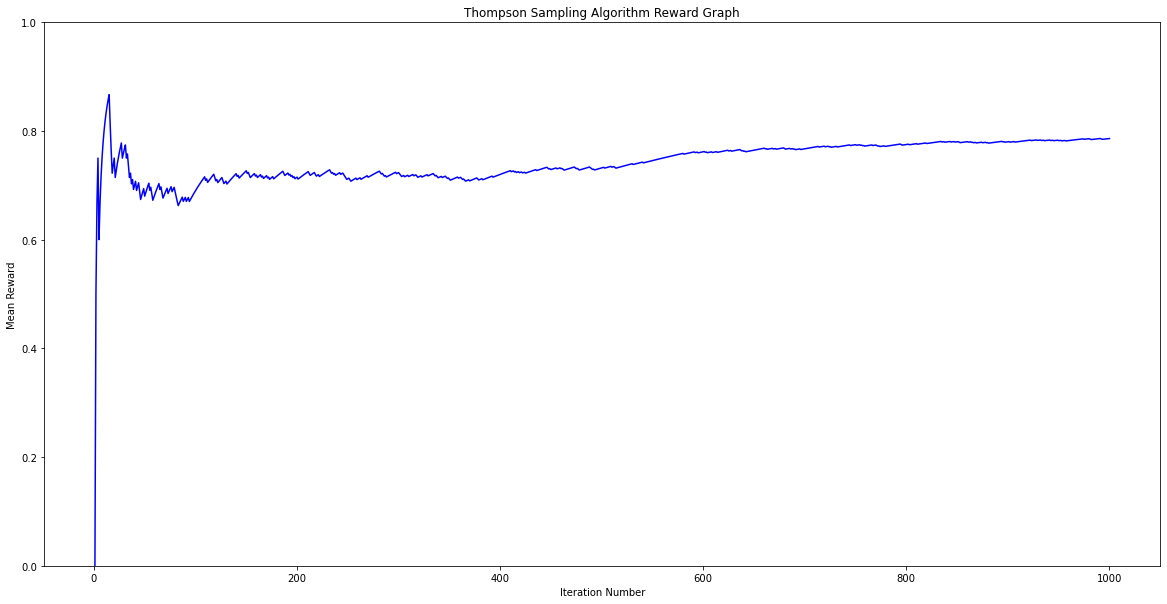

In [60]:
# implementation of Thompson sampling algorithm
def update_bandit(self, reward: int, bandit_num: int):
    a, b = self.bandit_means[bandit_num]
    self.bandit_means[bandit_num] = (a + reward, b + 1 - reward)


def use_greedy(self) -> int:
    sample_arr = [np.random.beta(*params) for params in self.bandit_means]
    bandit_num = np.random.choice(np.argwhere(sample_arr == np.max(sample_arr)).squeeze(axis=1))
    return bandit_num

    
bandit_probs = [0.2, 0.34, 0.56, 0.67, 0.81]
colors = ['r', 'g', 'c', 'm', 'k']

agent = Agent(bandit_probs)
agent.set_agent_algorithm(use_greedy)
agent.update_bandit = update_bandit.__get__(agent)
agent.bandit_means = [(1, 1)] * len(agent.bandits)
experiment = Experiment(agent)
experiment.run(1000)
experiment.plot_mean_rewards()
_ = plt.title("Thompson Sampling Algorithm Reward Graph")

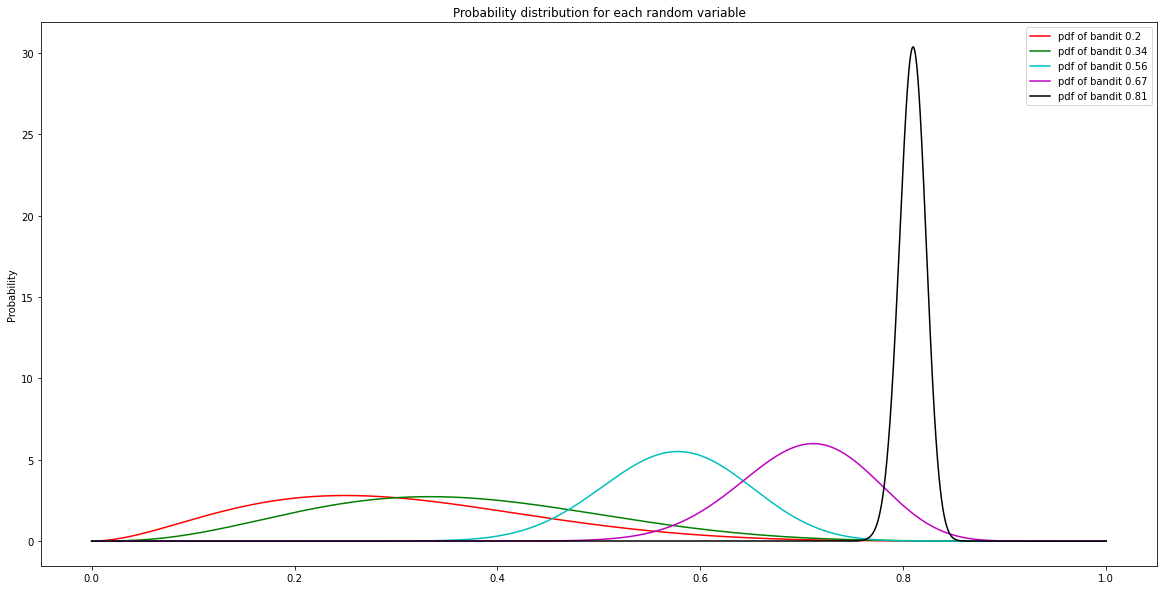

In [63]:
import scipy.stats as stats


final_beta_params = experiment.means[-1]
theta = np.linspace(0, 1, 10000)
legend = []
for i, params in enumerate(final_beta_params):
    pdf = stats.beta.pdf(theta, *params)
    plt.plot(theta, pdf, c=colors[i])
    legend.append("pdf of bandit {}".format(bandit_probs[i]))
_ = plt.legend(legend)
_ = plt.ylabel("Probability")
_ = plt.title("Probability distribution for each random variable")

We obtained 1000 samples for Thompson sampling algorithm and since the last bandit has the highest probability, most of the samples belong to that bandit. As a result, the bandit with the highest probabilty has the skinny distribution graph, and as the probability decreases, the distribution graph becomes fatter and larger since very few of the samples belong those bandits.

## Markov Decision Processes
Markow Decision Processes (MPDs) are the fundamental topic for reinforcement learning. All topics in reinforcement learning like Q-learning and all derivatives are results of MDPs.

### Gridworld
Gridworld is the perfect-sized environment to learn about reinforcement learning. In the gridworld, there is a simple map like Pacman and there is one obstacle, one punisment cell and one reward cell; an example is given in the figure below:

![](./images/image3.png)

- Learning = Reinforcing desired behavior
- Each iteration in the game is an __episode__.
- A __terminal state__ is the state that ends an episode.
- The duration of an episode is from the initial state to terminal state.
- __Environment__ is the world where the agent work.
- __Policy__ is a function that maps state to action; it's kind of agent's brain.
- Engineers' job is to design the reward in such a way that it results in the behavior that we want.

### The Markov Property
_All models are wrong, but some are useful. - George Box_

Assume $s_t$ represents the state of a system at time $t$. The Markow property can be stated like this: It says that even though the state of $t$ could depend on the state of $t-1$ all the way down to the satate at $t=1$ let's assume that the state is independent of any state earlier than $t-1$.

The first-order Markov assumption: 

$$ p(s_t | s_{t-1}, s_{t-2}, ... , s_1) = p(s_t | s_{t-1}) $$

> Hidden Markov models were state-of-the-art in speech recognition.

**State Transition Matrix:** We can estimate these probabilities using maximum likelihood. For Markov decision processes, we will have something similar but with more ingredients: $$ A_{ij} = p(s_t = j | s_{t-1} = i) \approx \frac{count(i \rightarrow j)}{count(i)} $$

### Markov Decision Processes (MPPs)
- Markov decision process is a discrete-time stochastic control process.
For the notation purposes, let $S_{t}$ represents the state of the model at time $t$. Similarly, let $R_t$ represents the reward at time $t$. Also, let $s$ be the current state, and $a$ is the action chosen by the agent. Then, the state transition probability can be stated as 

$$ S_{t+1}, R_{t+1} \sim   p(s', r | s, a) $$ 

and the action can be stated as $A_t \sim \pi(a_t | s_t)$

> State diagram can be used for MDPs where graph path weights are probabilities for state changes, but generally, there are lots of states in the agent; thus, such a representation can be difficult to draw.

> A better representation for reinforcement learning systems is state-action diagrams, but again if there are lots of actions and states, it will bi diffucult to show.

In reinforcement learning, we may have or may not have a clear information about the environment and control. Based on these conditions, we can separate used models to 4 pars as given in the table below:

|   | States are fully observed | States are partially observed |
|:--- | :----: | :---: |
| **System is autonomous** | Markov Model | Hidden Markov Model (HMM) |
| **System is controlled** | Markov Decision Process (MDP) | Partially-Observable MDP (POMDP) |

- We want to maximize the sum of rewards: $r_1 + r_2 + ... + r_T$
- We can't affect the past, we can only affect the future, so the goal at any given moment is to maximize sum of _future_ rewards. Let $G(t)$ be the sum of future rewards the return and since each reward in the future is a random variable, $G$ becomes also a random variable: 

$$ G(t) = \sum^{\infty}_{\tau = 0} R(t + \tau + 1) $$

This is the key feature which makes reinforcement learning so powerful. In supervised learning, you can give a plan to the model. However, you can't give the agent a plan, that isn't learning. RL has planning built-in. By simply maximizing the sum of future rewards, the agent comes up with whatever plan is necessary automatically.

### Discounting for Sum of Future Rewards
In some cases, the introduce a new variable $\gamma < 1$ to the equation for $G$ as: 

$$ G(t) = R(t + 1) + \gamma R(t+2) + \gamma^2 R(t+3) + ... $$ 

$$ G(t) = \sum^{\infty}_{\tau = 0} \gamma^\tau R(t + \tau + 1) $$

With such a modification, the reward closest to current time frame will have higher importance. The logic behind it can be expressed in finance: In order to get the highest gain and prevent the loss caused by inflation, it's important to take the gain as soon as possible.

> In here $\gamma$ is a hyperparameter to be choosen by user

> **Another reason for discounting:** Without discounting, the sum of future rewards is potentially infinite; so if the sum of future rewards is infinite for several states, then how does the agent make a decision?f

### Value Function
In the reinforcement learning concept, some environments like gridworld are deterministic and in those environments, the value function can be known exactly. However, in some other environments like tic-tac-toe or chess, there are other opponents and their movements are unknown. Hence, the reward function is unknown or more conveniently it is random. Hence, we want to maximize the expected return: 

$$ V_\pi(s) = E_\pi[G(t) | S_t = s) $$

We will call this function is the __value function__ or simply value, and the purpose of the course is designing algorithms to solve the value function.

### Bellman Equation
By using recursion, at time $t=1$ we can obtain the sum of future rewards as: 

$$ G_1 = R_2 + R_3 + ... + R_T $$ and similarly for $t=2$: 

$$ G_2 = R_3 + ... + R_T $$ Then by substution, we get:

$$ G_1 = R_2 + G_2 $$ or more generally, 

$$ G(t) = R(t+1) + G(t+1) $$

This equation is obtained for sum of future rewards without discounting, so if we use discounting, the equation becomes: 

$$ G(t) = R(t+1) + \gamma G(t+1) $$ which is easy to prove.

By using this function, the value function becomes: $$ V_\pi(s) = E_\pi[G(t) | S_t=s] $$

$$ V_\pi(s) = E_\pi[R(t+1) + \gamma G(t+1) | S_t=s] $$

<u>__Law of Total Expectation:__</u>
$$ E(E(X|Y)) = E[\sum_x xp(x|Y)] $$

$$ E(E(X|Y)) = \sum_y[\sum_x xp(x|y)]p(y) $$

$$ E(E(X|Y)) = \sum_y \sum_x xp(x|y)p(y) $$

$$ E(E(X|Y)) = \sum_y \sum_x xp(x, y) $$

$$ E(E(X|Y)) = \sum_x x \sum_y p(x, y) $$

$$ E(E(X|Y)) = \sum_x xp(x) $$

$$ E(E(X|Y)) = E(X) $$

Let's use this law of total expectations for our case:

$$ V_\pi(s) = E_\pi[G(t) | S_t] $$

$$ V_\pi(s) = E_\pi[R(t+1) + \gamma G(t+1) | S_t=s] $$

$$ V_\pi(s) = E_\pi[R(t+1) | S_t = s] + \gamma E_\pi[G(t+1) | S_t=s] $$

$$ V_\pi(s) = E_\pi[R(t+1) | S_t = s] + \gamma E_\pi[G(t+1) | S_t=s] $$

$$ V_\pi(s) = E_\pi[R(t+1) | S_t = s] + \gamma E_\pi[E_\pi\{G(t+1) | S_{t+1}=s'\} | S_t=s] $$

$$ V_\pi(s) = E_\pi[R(t+1) + \gamma V_\pi (s') | S_t = s ] $$

The last equation is called as _Bellman Equation_ and it is used for calculating the value of the current state depends only on the possible next states. Hence, we don't need to search an entire probability tree, we only need the values for one step ahead. The real definition for value function can be written as:

$$ V_\pi(s) = \sum_{s'} \sum_r \sum_a \pi(a | s)p(s', r| s, a)\{r + \gamma V_\pi(s')\} = \sum_a \pi(a | s) \sum_{s'} \sum_r p(s', r| s, a){r + \gamma V_\pi(s')}$$

$$ V_\pi(s) = \sum_a \pi(a | s) \sum_{s'} \sum_r p(s', r| s, a)\{r + \gamma V_\pi(s')\} $$

If the reward is not probabilistic, this equation can be rewritten as

$$ V_\pi(s) = \sum_a \pi(a | s) \sum_{s'} \sum_r p(s'| s, a)\{r(s, a, s') + \gamma V_\pi(s')\} $$

This equation depends on current state, previous state and the action. If we think each state as a separate equation, then Bellman equation becomes a linear system equation.

---

In general, we can use 2 kinds of value functions:

1. state - value: $ V_\pi(s) = E_\pi [G(t) | S_t = s] $

2. action - value: $ Q_\pi(s, a) = E_\pi [G(t) | S_t = s, A_t=a] $

If one uses action - value function, then the values for $Q_\pi$ can be stored as a table which is called Q-table.

<u> __Bellman Equation for Action-Value:__ </u> 


By using the same approach in in state - value, we get:

$$ Q_\pi(s, a) = E_\pi[R(t + 1) + \gamma \sum_{a'} \pi(a' | s')Q_\pi(s', a') | S_t = s, A_t = a] $$

The relationship between state - value and action - value functions can be obtained as:

$$ V_\pi(s) = \sum_a \pi(a|s)Q_\pi(s, a) $$

- $V(s)$ is useful for evaluating a policy.
    Given a policy, what is the return I can expect?
- $Q(s, a)$ is useful for control
    - I'm in state s, what is the best action to take
    - i.e. Compare $Q_\pi(s, a_1)$, $Q_\pi(s, a_2)$, take the action which has the grater value

These are the main algorithms will